In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
from datetime import datetime
from jupyterthemes import jtplot
jtplot.style()
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf


In [2]:
np.random.seed(123)
tf.random.set_seed(123)
end=datetime.now()

Extracting the data from yahoo finance

Close price

The company data to be analyzed is downloaded

In [3]:
# MSFT data
stock=yf.download('MSFT','2012-01-01',end)

[*********************100%***********************]  1 of 1 completed


In [4]:
stock.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-17,278.260010,283.329987,276.320007,279.429993,279.429993,69492200
2023-03-20,276.980011,277.480011,269.850006,272.230011,272.230011,43466600
2023-03-21,274.880005,275.000000,269.519989,273.779999,273.779999,34558700
2023-03-22,273.399994,281.040009,272.179993,272.290009,272.290009,34873300
2023-03-23,277.940002,281.059998,275.200012,277.660004,277.660004,36590300


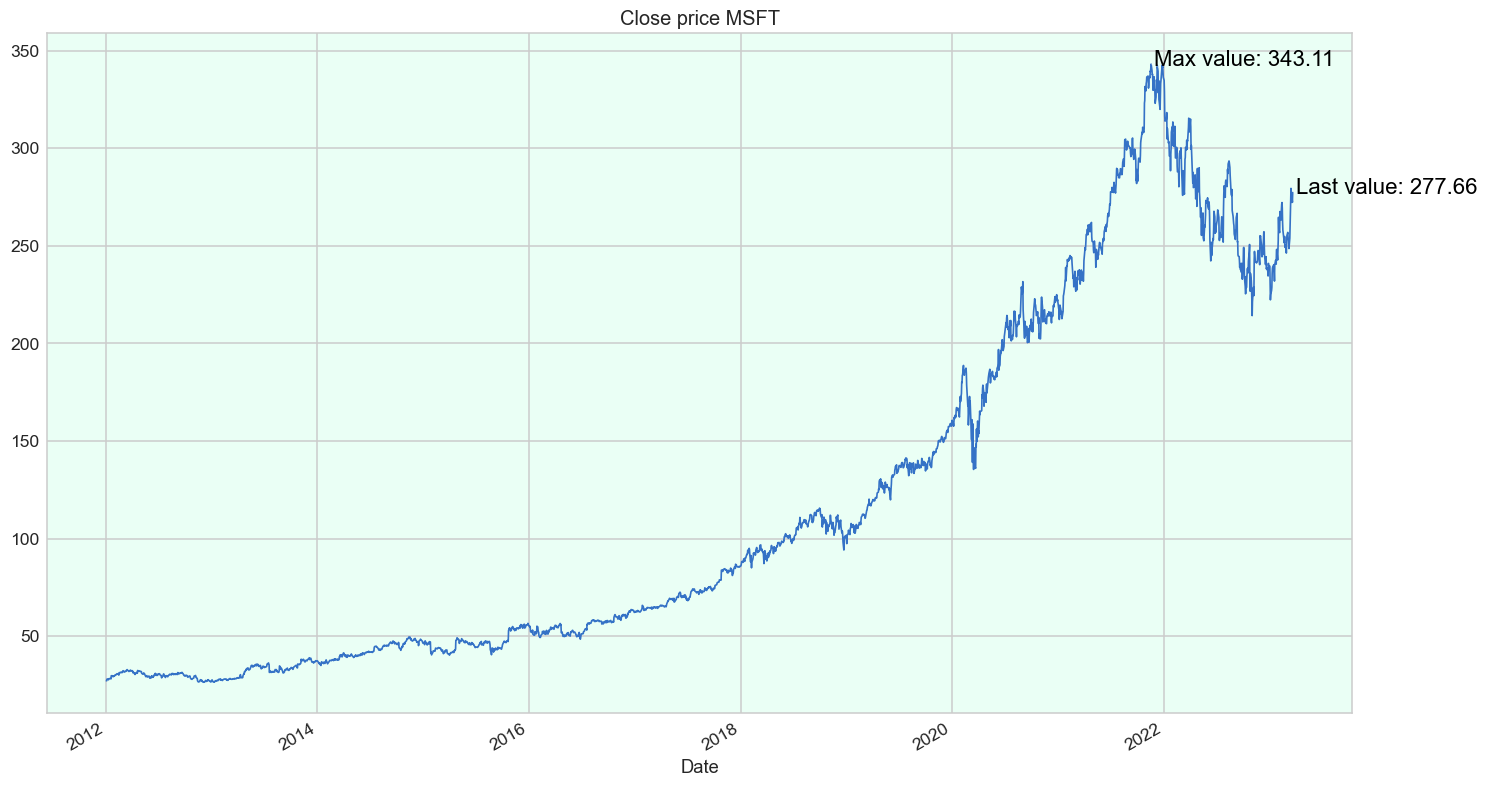

In [21]:
jtplot.style()
fig,ax=plt.subplots(figsize=(15,10))
stock['Close'].plot()
max_value=stock['Close'].max()
max_index=stock['Close'].idxmax()
last_value=stock['Close'][-1]
last_index=stock['Close'].tail(1).idxmax()
ax.set_title('Close price MSFT')
ax.annotate(f'Max value: {max_value:.2f}', 
            xy=(max_index, max_value),
            xytext=(max_index + np.timedelta64(10, 'D'), max_value -1), 
            arrowprops=dict(facecolor='blue', arrowstyle='->'),
            fontsize=16,color='black')
ax.annotate(f'Last value: {last_value:.2f}', 
            xy=(last_index, last_value),
            xytext=(last_index + np.timedelta64(10, 'D'), last_value -1), 
            arrowprops=dict(facecolor='blue', arrowstyle='->'),
            fontsize=16,color='black')
ax.set_facecolor('#eafff5')

plt.show()

splitting the data into training and test

In [6]:
rmse_stock=[]

In [7]:
def stock_predictions(data,ln):
    stock_close_1=stock.filter(['Close'])
    stock_close=stock_close_1.values
    training_data_len = int(np.ceil( len(stock_close) *ln))
    dif_len=len(stock_close)-training_data_len
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(stock_close)
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []
    for i in range(dif_len, len(train_data)):
        x_train.append(train_data[i-dif_len:i, 0])
        y_train.append(train_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

# Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    # Create the testing data set
    test_data = scaled_data[training_data_len - dif_len: , :]
# Create the data sets x_test and y_test
    x_test = []
    y_test = stock_close[training_data_len:, :]
    for i in range(dif_len, len(test_data)):
        x_test.append(test_data[i-dif_len:i, 0])
    
# Convert the data to a numpy array
    x_test = np.array(x_test)

# Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    rmse_stock.append(rmse)
    print(rmse)

In [8]:
lengths=[.75,.8,.85,.9,.95]

In [9]:
for i in lengths:
    stock_predictions(stock,i)

23/23 [==============================] - 8s 276ms/step
14.543376067872057
18/18 [==============================] - 6s 230ms/step
11.99929739019517
14/14 [==============================] - 2s 95ms/step
10.651816669561217
9/9 [==============================] - 2s 75ms/step
9.83999851803064
5/5 [==============================] - 1s 36ms/step
8.04167245431655


In [10]:
rmse_stock

[14.543376067872057,
 11.99929739019517,
 10.651816669561217,
 9.83999851803064,
 8.04167245431655]

In [11]:
min_lengths_rmse=[rmse_stock.index(min(rmse_stock))]
min_length=lengths[min_lengths_rmse[0]]
min_length

0.95

In [12]:
stock_predictions(stock,min_length)

5/5 [==============================] - 1s 40ms/step
8.045102835503368


In [13]:
stock_close_1=stock.filter(['Close'])
stock_close=stock_close_1.values
training_data_len = int(np.ceil( len(stock_close) *min_length))
dif_len=len(stock_close)-training_data_len
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stock_close)
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []
for i in range(dif_len, len(train_data)):
    x_train.append(train_data[i-dif_len:i, 0])
    y_train.append(train_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))



In [14]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2542/2542 [==============================] - 98s 37ms/step - loss: 0.0011


In [15]:
# Creating the testing data set
test_data = scaled_data[training_data_len - dif_len: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = stock_close[training_data_len:, :]
for i in range(dif_len, len(test_data)):
    x_test.append(test_data[i-dif_len:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [16]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)

5/5 [==============================] - 1s 36ms/step
8.476895629906267


In [17]:
# Plot the data
valid = stock_close_1[training_data_len:]
valid = pd.DataFrame(valid, columns=['Close'])
valid['Predictions'] = predictions
train = stock_close_1[:training_data_len]

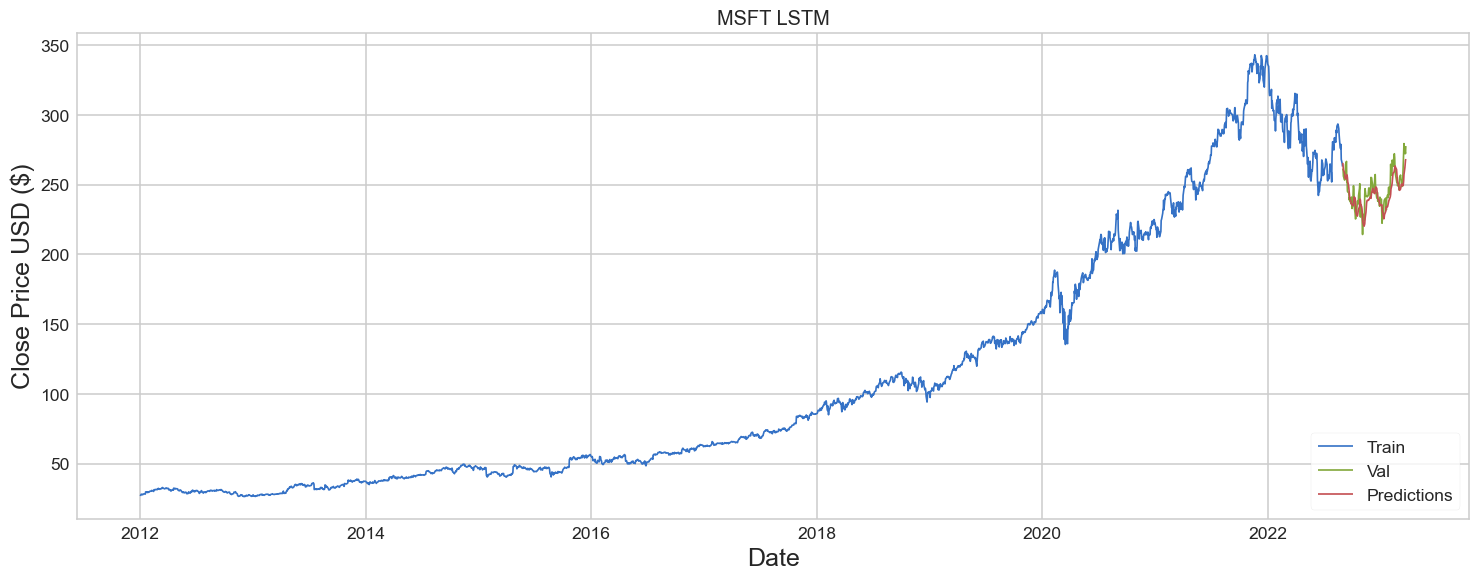

In [22]:
# Visualize the data
jtplot.style()
plt.figure(figsize=(16,6))
plt.title('MSFT LSTM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

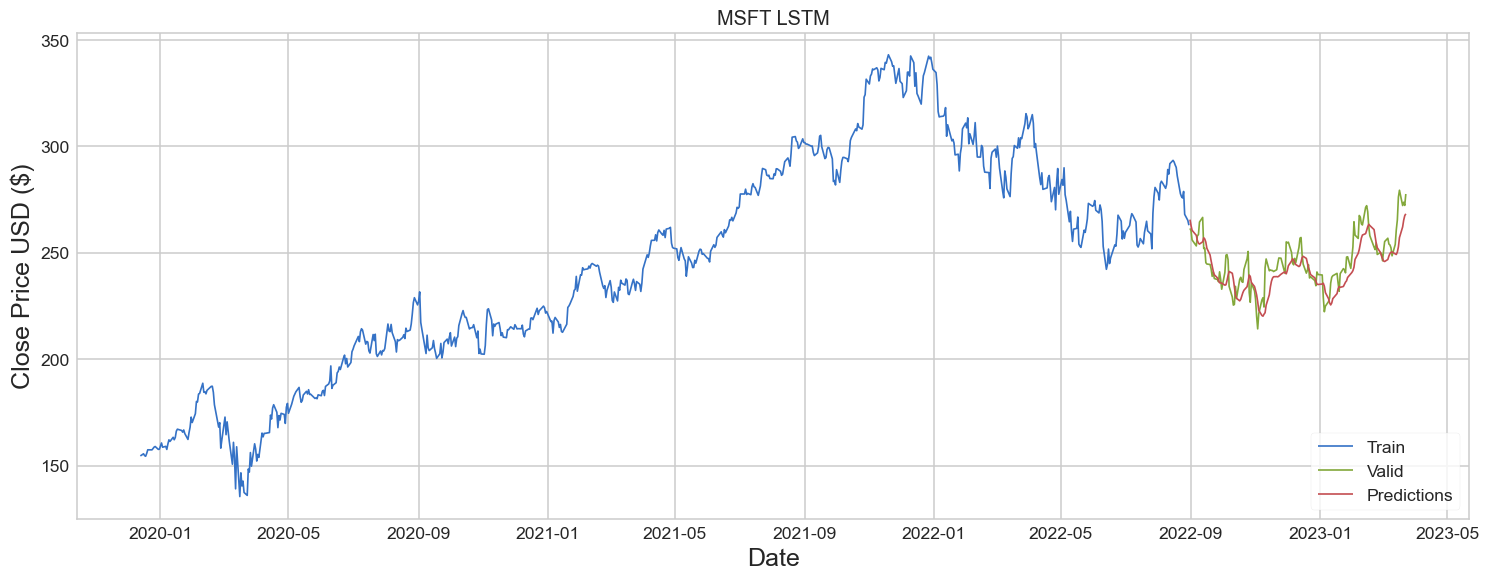

In [23]:
# Visualize the data
jtplot.style()
plt.figure(figsize=(16,6))
plt.title('MSFT LSTM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'][2000:])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

In [20]:
#Get the latest "dif_len" normalized closing prices
last_dif_len_prices = scaled_data[-dif_len:]

x = np.array([last_dif_len_prices])

# Prediction using the neural network model
prediction_tomorrow = model.predict(x)

# Denormalize the prediction to obtain the value of the action
predicted_price_tomorrow = scaler.inverse_transform(prediction_tomorrow)[0][0]
print(f'The predicted price for tomorrow {datetime.now().strftime("%Y-%m-%d")} is {predicted_price_tomorrow} ')

1/1 [==============================] - 0s 36ms/step
The predicted price for tomorrow 2023-03-24 is 269.4097900390625 
